In [90]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
from format_rules import format_rules
#from server_association import server_association
from Server_Assign import server_association
#from apyori import apriori 

In [91]:
#load data
#df=pd.read_csv('/home/natalie/Documents/Manifold/df_test.csv')
client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()), low_memory=False)


df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")


In [92]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])
#create a normalized latency column = duration/packets
df['norm_latency']=df['Duration']/df['Packets']

In [93]:
def convert_si_to_number(x):
    total_stars = 0
    if 'k' in x:
        if len(x) > 1:
            total_stars = float(x.replace('k', '')) * 1000 # convert k to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000 # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000 # convert B to a Billion
    else:
        total_stars = int(x) # Less than 1000
    return int(total_stars)

In [94]:
df.Bytes=df.Bytes.astype('str')
test_list=df.Bytes

[i for i, s in enumerate(test_list) if 'M' in s]#show where the M errors are happening

test_list= [convert_si_to_number(x) for x in test_list]
df.Bytes=test_list #bring it back into the dataframe


In [95]:
#add hour column, where it is a value 1-24, and repeats each day
df['hour']=None
df['hour']=pd.DatetimeIndex(df['Date']).hour

#lambda x: x[0]).head()

In [96]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency,hour
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0015,0
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0000,0
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0020,0
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)",0.0000,0
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0000,0


how many transactions do we have?

In [97]:
len(df)

8185992

## Implement Frequent Pattern (FP) - Growth algorithm

https://fp-growth.readthedocs.io/en/latest/usage.html

This algorithm
1. Counts occurence of items in dataset in 1st pass
2. Build FP-tree by inserting instances, and adds count to each instance based on the number of times it appears in the dataset. Those infrequent instances are dropped from the tree.

This allows the frequentest set to be generated organically, instead of creating a list of each itemset and checking if it does/does not pass minimum threshold (like Apriori algorithm)

#### Vocabulary
 - itemset = all items in 1 transaction
A "pattern" is a conjunction of items, or the unique itemset.
A "rule" X --> Y means if you buy X you are likely to buy Y, or in this case if X IP address is used Y IP address is likely also


#### Evaluation metrics include:

1. Support = how frequently it occurs. The number of transactions of that unique itemset / all transactions. In this case: number of times IP pair occurs/all requests

2. Confidence = how often rule is likely to be true. frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. P(Ey|Ex)

3. Lift = How likely is item Y given item X occurs, controlling for how frequent Y occurs in the entire dataset. For rule X-->Y, lift = P(Y|X)/P(Y).
    Lift = 1 means X and Y are independent
    Lift >1 = X and Y are positively correlated
    Lift <1 = X and Y are negatively correlated

## 2. Implement Frequentest paterns algorithm

Before we run this algorithm, we should have some idea of the minimum threshold we want to set. This is the "support" for each IP pair. Support = % of time this pair occurs in dataset.

### Do this for each hour in the dataset, we think that frequency in pairs might change with time.

In [98]:
data_groups=[]

for i in range(0,25):
    data=df[df['hour']==i]
    data_groups.append(data)

In [99]:
#make individual 'pairs count' frequency tables so we can get a good value for our minimum support and keep it consitent.
#We are selecting the 80th percentile as our min threshold, so each group will ahve a different 80th value.

pairs_count=(df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by 
np.percentile(pairs_count['frequency'], [80])[0]

126.0

In [100]:
pairs_list=[]
per80_list=[]
data_l_list=[]
patterns_list=[]
rules_list=[]
confidence=0.7 #this means the rule is likely to be true 20% of the time, it is a high threshold, used for testing


for i in data_groups:    
    data_l=list(i['pairs'])
    pairs_count=(i.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
    pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
    pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair
    pairs_list.append(pairs_count)
    per_80=(pairs_count['frequency'].quantile(.8))
    patterns = pyfpgrowth.find_frequent_patterns(data_l, per_80) 
    patterns_list.append(patterns)
    rules = pyfpgrowth.generate_association_rules(patterns, confidence)
    rules_list.append(rules)
      

In [101]:
#format the rules, bring back in the other info on latency rank
rules_list=rules_list[:-1]#last item was empty, remove it
formated_rules=[]
apps_server=20

for i in rules_list:
    formatrule=format_rules(i, df, apps_server)
    formated_rules.append(formatrule)


## Assign Servers to each IP address in the rules dataframe

Start with the highest rank IP pair, assign matching servers and then move on to the next highest rank pair until that server is full. This is a 'dumb' approach, but  it clearly assigns things based on priority and gets a proof of concept. Because IP addresses repeat throughout the rules dataset, we will remove repeated IPs leaving the highest ranked IP.

For this exercise we assume a server can hold 20 apps, or 10 pairs

In [102]:
range(len(formated_rules))

range(0, 24)

In [103]:
#assign IPs to the servers at each hour
server_assign_list=[]
total_latency_list=[]
total_latency_model_list=[]
avg_latency_list=[]
avg_latency_model_list=[]


for i, j in zip(formated_rules, data_groups) :
    server_df, server_assignments, total_latency, total_latency_model, avg_latency, avg_latency_model = server_association(i, j, apps_server) #this function loaded fr
    server_assign_list.append(server_assignments)
    total_latency_list.append(total_latency)
    total_latency_model_list.append(total_latency_model)
    avg_latency_list.append(avg_latency)
    avg_latency_model_list.append(avg_latency_model)
    

In [104]:
#original times

df_hour=df.groupby('hour')['Duration'].sum()

In [105]:
#bring together all the durations for the actual data and the model
hours=range(0,24)
model_output=pd.DataFrame({'hours':hours,'total_latency_list': total_latency_list, 'total_latency_model_list': total_latency_model_list, 'avg_latency_list': avg_latency_list, 'avg_latency_model_list': avg_latency_model_list})
model_output.columns=['hours', 'total_latency', 'total_latency_model', 'avg_latency', 'avg_latency_model']
model_output['avg_latency_per_reduction']=((model_output['avg_latency']-model_output['avg_latency_model'])/model_output['avg_latency'])*100
model_output

,hours,total_latency,total_latency_model,avg_latency,avg_latency_model,avg_latency_per_reduction
0,0,2520.962,1131.550,0.060149,0.026998,55.114357
1,1,2556.084,1292.347,0.069988,0.035385,49.440355
2,2,2584.281,1100.764,0.069887,0.029768,57.405406
3,3,2634.629,1331.878,0.071291,0.036040,49.447228
4,4,3074.361,1448.215,0.083327,0.039252,52.893788
5,5,2269.169,1017.308,0.069784,0.031285,55.168258
6,6,8304.769,7459.399,0.106899,0.096017,10.179332
7,7,27839.168,26686.208,0.125774,0.120565,4.141503
8,8,39943.202,31936.169,0.156812,0.125378,20.046047
9,9,126588.410,124126.985,0.167181,0.163930,1.944432


In [106]:
time=['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4ppm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']

How did this model do?

In [107]:
model_output['total_latency'].sum() #original total latency

2014119.5810000002

In [108]:
model_output['total_latency_model'].sum()#predicted latency, does not match the other output.... what is wrong...

1679517.0219999999

## Overall, this is a % improvement in total latency:

In [109]:
(model_output['total_latency'].sum()-model_output['total_latency_model'].sum())/model_output['total_latency'].sum()

0.16612844746480834

What about average transaction time?

In [110]:
model_output['avg_latency'].mean()

0.1826211027930775

In [111]:
model_output['avg_latency_model'].mean()

0.13251332695377088

In [112]:
#each hour the avg transaction time is averaged for a overall avg

model_output['avg_latency_per_reduction'].mean()

31.183755441592822

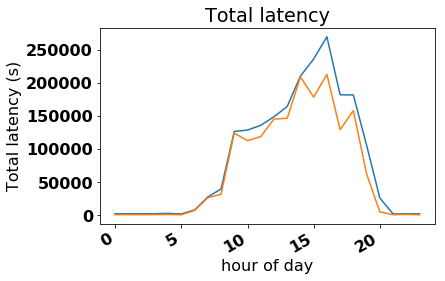

In [113]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
ax.plot(model_output['hours'], model_output['total_latency'])
ax.plot(model_output['hours'], model_output['total_latency_model'])


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Total latency (s)')
plt.xlabel('hour of day')
plt.title('Total latency')
plt.show()

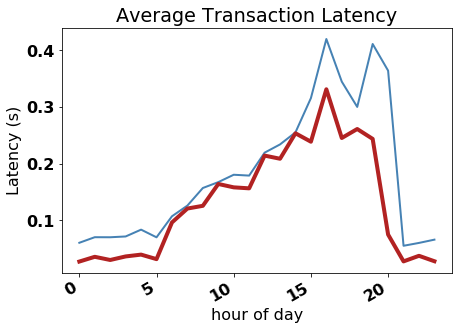

In [114]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(model_output['hours'], model_output['avg_latency'], color='steelblue', linewidth=2.0)
ax.plot(model_output['hours'], model_output['avg_latency_model'], color='firebrick', linewidth=4.0)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency')
fig.savefig('Average_transaction_latency_hours_day1.png')

## Same analysis but subset the data for training and testing

use the first 5 days for training, and the last 2 days for testing. Even though this covers weekends, which are in the training dataset, because of the relatively small amount of transactions on the weekend, it is not likely to skew the results.

In [115]:
train_df=df[df['Date']<'2017-08-08'] #first 6 days

In [116]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency,hour
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0015,0
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0000,0
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0020,0
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)",0.0000,0
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0000,0


In [117]:
test_df=df[df['Date']>'2017-08-08'] #last day

In [118]:
len(test_df)

1830704

In [119]:
len(train_df)

6355288

In [120]:
#training data

data_groups_t=[]

for i in range(0,25):
    data=train_df[train_df['hour']==i]
    data_groups_t.append(data)

In [121]:
len_groups=[]
for i in data_groups_t:
    len_groups.append(len(i))

In [122]:
sum(len_groups)

6355288

In [123]:
#make individual 'pairs count' frequency tables so we can get a good value for our minimum support and keep it consitent.
#We are selecting the 80th percentile as our min threshold, so each group will ahve a different 80th value.

pairs_count_t=(train_df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
pairs_count_t.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count_t['norm_latency']=(pairs_count_t['total_duration']/pairs_count_t['total_packets'].sum())*100 #sum of all duration time divided by 
np.percentile(pairs_count_t['frequency'], [80])[0]

pairs_list_t=[]
per80_list_t=[]
data_l_list_t=[]
patterns_list_t=[]
rules_list_t=[]
confidence=0.7 #this means the rule is likely to be true 70% of the time


for i in data_groups_t:    
    data_l_t=list(i['pairs'])#the IP pairs are now a list of lists
    pairs_count_t=(i.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
    pairs_count_t.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
    pairs_count_t['norm_latency']=(pairs_count_t['total_duration']/pairs_count_t['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair
    pairs_list_t.append(pairs_count_t)
    per_80=(pairs_count_t['frequency'].quantile(.8))
    patterns = pyfpgrowth.find_frequent_patterns(data_l_t, per_80) 
    patterns_list_t.append(patterns)
    rules = pyfpgrowth.generate_association_rules(patterns, confidence)
    rules_list_t.append(rules)
   

In [124]:
#format the rules, bring back in the other info on latency rank, based on the training data
rules_list_t=rules_list_t[:-1]#last item was empty, remove it
formated_rules_train=[]
apps_server=20

for i in rules_list_t:
    formatrule=format_rules(i, train_df, apps_server)
    formated_rules_train.append(formatrule)


In [126]:
#assign IPs to the TEST servers at each hour, 
#NOW WE ASSIGN SERVERS TO THE TETING DATA BASED ON THE TRAINING DATA USED ABOVE

server_assign_list_test=[]
total_latency_list_test=[]
total_latency_model_list_test=[]
avg_latency_list_test=[]
avg_latency_model_list_test=[]
df_server_list=[]


for i, j in zip(formated_rules_train, data_groups_test) :
    df_servers, server_assignments, total_latency, total_latency_model, avg_latency, avg_latency_model = server_association(i, j, apps_server) #this function loaded fr
    df_server_list.append(df_servers)
    server_assign_list_test.append(server_assignments)
    total_latency_list_test.append(total_latency)
    total_latency_model_list_test.append(total_latency_model)
    avg_latency_list_test.append(avg_latency)
    avg_latency_model_list_test.append(avg_latency_model)
    

In [127]:
server_assign_list_test

[                            IP  serverid
 10003_235            10003_235       1.0
 10013_226            10013_226       1.0
 10013_228            10013_228       0.0
 10013_238            10013_238       0.0
 10027_194            10027_194       1.0
 10030_142            10030_142       0.0
 10138_81              10138_81       0.0
 11396_56              11396_56       0.0
 11681_180            11681_180       0.0
 11685_203            11685_203       0.0
 11714_20              11714_20       0.0
 12204_156            12204_156       1.0
 192.168.100.11  192.168.100.11       0.0
 192.168.210.45  192.168.210.45       0.0
 192.168.210.46  192.168.210.46       0.0
 192.168.210.47  192.168.210.47       0.0
 192.168.210.48  192.168.210.48       0.0
 192.168.210.53  192.168.210.53       0.0
 192.168.210.54  192.168.210.54       0.0
 192.168.210.56  192.168.210.56       0.0
 192.168.210.57  192.168.210.57       0.0
 192.168.220.43  192.168.220.43       0.0
 192.168.220.44  192.168.220.44   

In [128]:
#bring together all the durations for the actual data and the model
hours=range(0,24)
model_output_test=pd.DataFrame({'hours':hours,'total_latency_list': total_latency_list_test, 'total_latency_model_list': total_latency_model_list_test, 'avg_latency_list': avg_latency_list_test, 'avg_latency_model_list': avg_latency_model_list_test})
model_output_test.columns=['hours', 'total_latency', 'total_latency_model', 'avg_latency', 'avg_latency_model']
model_output_test['avg_latency_per_reduction']=((model_output_test['avg_latency']-model_output_test['avg_latency_model'])/model_output_test['avg_latency'])*100
model_output_test

,hours,total_latency,total_latency_model,avg_latency,avg_latency_model,avg_latency_per_reduction
0,0,1181.750,1180.314,0.053512,0.053447,0.121515
1,1,1068.873,1064.958,0.064565,0.064328,0.366274
2,2,1346.696,1333.177,0.074704,0.073954,1.003864
3,3,1171.800,1171.628,0.068191,0.068181,0.014678
4,4,1857.150,1856.971,0.087325,0.087317,0.009638
5,5,1628.038,1627.674,0.086304,0.086285,0.022358
6,6,3233.341,3096.209,0.096978,0.092865,4.241186
7,7,3271.897,3121.813,0.111829,0.106699,4.587064
8,8,3172.261,3130.169,0.119406,0.117822,1.326877
9,9,24430.228,24383.342,0.141347,0.141075,0.191918


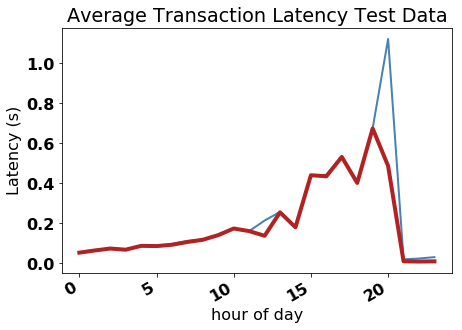

In [129]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib as matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(model_output_test['hours'], model_output_test['avg_latency'], color='steelblue', linewidth=2.0)
ax.plot(model_output_test['hours'], model_output_test['avg_latency_model'], color='firebrick', linewidth=4.0)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency Test Data')
fig.savefig('Average_transaction_latency_hours_day_Test.png')

In [130]:
model_output_test['total_latency'].sum()#total latency, 

506250.077

In [131]:
model_output_test['total_latency_model'].sum()#predicted latency, 

486198.29099999997

We performed how much better, %:

In [132]:
(model_output_test['total_latency'].sum()-model_output_test['total_latency_model'].sum())/model_output_test['total_latency'].sum()

0.03960846014844166

The average transactional time before and after the model:

In [133]:
model_output_test['avg_latency'].mean()

0.23255458633382028

In [134]:
model_output_test['avg_latency_model'].mean()

0.1999132803586853

In [135]:
(model_output_test['avg_latency'].mean()-model_output_test['avg_latency_model'].mean())/model_output_test['avg_latency'].mean()

0.14035976021681226

## How does this compare to randomly assigning servers?

Figure out how many IPs were assigned based on our model, then randomly assign servers to the same amount of IPs

In [136]:
df_server_test = pd.concat(df_server_list)

In [137]:
lengthts=[]
for i in df_server_list:
    lengthts.append(len(i))

In [138]:
sum(lengthts)

1830704

In [139]:
len(df_server_test) #should match originial test data length

1830704

In [140]:
len(test_df)

1830704

In [141]:
#need to assign random servers to the IP addressed, however b/c we did not assign a server to all the IP addresses in our model run, we will only assign servers to the same proportion of the data.

#how many servers did we assign in the Src_server column?
num_src_assign=test_df['Src_Server'].count()
num_dst_assign=test_df['Dst_Server'].count()

xx_src=np.random.choice(len(test_df), num_src_assign) #which rows are randomly assigned src servers
xx_dst=np.random.choice(len(test_df), num_dst_assign) #which rows are randomly assigned dst servers
num_servers=server_rules['serverid'].nunique()
test_df['rnd_src_server']=None
test_df['rnd_dst_server']=None

KeyError: 'Src_Server'

In [ ]:
rnd_src_servers=[]
for x in range(len(xx_src)):
  rnd_src_servers.append(random.randint(0,num_servers))

In [ ]:
rnd_dst_servers=[]
for x in range(len(xx_dst)):
  rnd_dst_servers.append(random.randint(0,num_servers)) #create random numbers for dst serve

In [ ]:
test_df['rnd_src_server'][xx_src]=rnd_src_servers
test_df['rnd_dst_server'][xx_dst]=rnd_dst_servers

In [ ]:
len(test_df[df_servers.rnd_src_server==df_servers.rnd_dst_server])/len(df_servers) #we only get 0.9% matching pairs

In [ ]:
df_servers['duration_rnd']=df_servers['Duration']
df_servers['duration_rnd'][df_servers['rnd_src_server']==df_servers['rnd_dst_server']]=0 #if random servers match, set latency time=0